In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Inverse cotangent (useful)
def inverse_cot(cota):
    a = np.array(np.arctan(1.0/cota))
    a[np.where(a<0)] = a[np.where(a<0)] + np.pi    
    return a 

In [3]:
# From Sofi
def shortest_interval_68(data, center_type='mean'):
    """
    Compute the shortest interval that contains 68% of the data.
    """
    data = np.sort(data)
    n = len(data)
    ci_size = int(np.floor(0.68 * n))
    min_width = float("inf")
    min_i = 0

    for i in range(n - ci_size):
        width = data[i + ci_size] - data[i]
        if width < min_width:
            min_width = width
            min_i = i

    low = data[min_i]
    high = data[min_i + ci_size]

    if center_type == 'mean':
        center = np.mean(data)
    else:
        center = np.median(data)

    return {
        "center": center,
        "error_low": float(center - low),
        "error_high": float(high - center),
        "center_type": center_type
    }

In [4]:
# Pixel pitch (um)
xpitch = 50
ypitch = 12.5

# Thickness (um)
D = 100

# Size of pixel array
lenx = 16
leny = 16

# Lorentz angle from Morris
tan_ThetaL = 0.3046

In [5]:
# Select last time slice
t = 19

# Use these columns
data_indices = list(np.arange(t * lenx * leny, (t + 1) * lenx * leny).astype(str))
col_indices = ['x-midplane','cotAlpha','y-midplane','cotBeta'] + data_indices

In [6]:
# Read in the data
df = pd.DataFrame()
for i in range(80,100):
    df = pd.concat([df,pd.read_parquet("/eos/uscms/store/user/jennetd/smart-pixels/parquet/shuffled/dataset_3sr_16x16_50x12P5_parquets/test_contained/part."+str(i)+".parquet",columns=col_indices)])

In [7]:
# Get x- and y-profile projections
last_slice = (df[data_indices].values).reshape(len(df),16,16)

xprofile = np.sum(last_slice,axis=1)
yprofile = np.sum(last_slice,axis=2)

#ratio = (xprofile/xprofile)
#ratio[np.isnan(ratio)] = 0
#xsize = np.array(np.sum(ratio,axis=1))

In [8]:
# True x and y positions
xtrue = np.array(df['x-midplane'])
ytrue = np.array(df['y-midplane'])

In [9]:
# bins for histograms
xbins = np.linspace(-1*lenx*xpitch/4,lenx*xpitch/4,45)
ybins = np.linspace(-1*leny*ypitch/4,leny*ypitch/4,45)

In [10]:
# Calculate barycenter
def weighted_average(profile):
    return np.array([np.sum([(i*x)/np.sum(p) for i,x in enumerate(p)]) for p in profile])

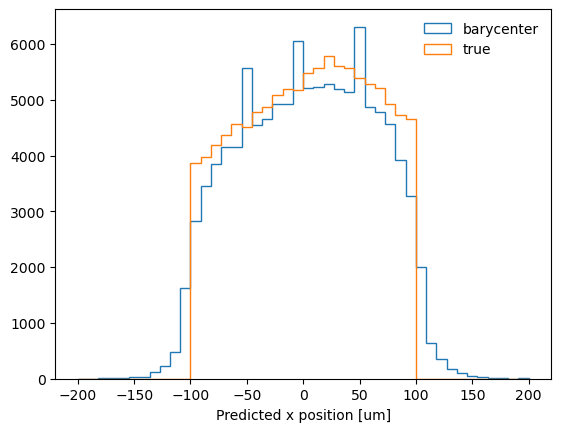

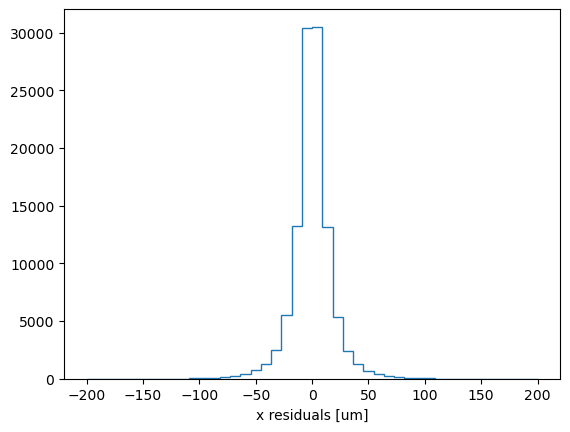

In [11]:
# Barycenter in x
xbarycenter = xpitch*(weighted_average(xprofile)-lenx/2 + 1)
plt.hist(xbarycenter,bins=xbins,histtype='step',label='barycenter')
plt.hist(xtrue,bins=xbins,histtype='step',label='true')
plt.xlabel("Predicted x position [um]")
plt.legend(frameon=False)
plt.show()

plt.hist(xbarycenter - xtrue,bins=xbins,histtype='step')
plt.xlabel("x residuals [um]")
plt.show()

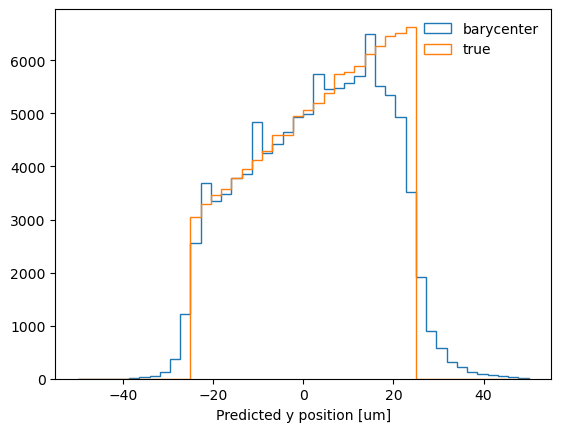

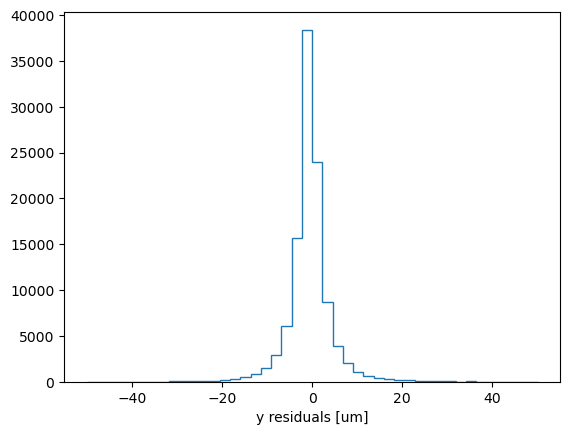

In [12]:
# Barycenter in y
ybarycenter = ypitch*(weighted_average(yprofile)-leny/2 + 1) -1*np.array(-1*D*tan_ThetaL/2.)
plt.hist(ybarycenter,bins=ybins,histtype='step',label='barycenter')
plt.hist(ytrue,bins=ybins,histtype='step',label='true')
plt.xlabel("Predicted y position [um]")
plt.legend(frameon=False)
plt.show()

plt.hist(ybarycenter - ytrue,bins=ybins,histtype='step')
plt.xlabel("y residuals [um]")
plt.show()

In [13]:
xresiduals = xbarycenter - df['x-midplane']
yresiduals = ybarycenter - df['y-midplane']

mean_x = np.mean(xresiduals)
mean_y = np.mean(yresiduals)

interval68 = shortest_interval_68(xresiduals, center_type='mean')
up68_x = interval68['error_high']
down68_x = interval68['error_low']

interval68 = shortest_interval_68(yresiduals, center_type='mean')
up68_y = interval68['error_high']
down68_y = interval68['error_low']

In [14]:
print(mean_x,up68_x,down68_x)

-0.09279213645228232 12.911197621251297 12.185558364110882


In [15]:
print(mean_y,up68_y,down68_y)

-0.5636358480934232 2.8459339863505595 3.0855832481540264


In [16]:
def hit_position(df, corr1 = True, corr2=True):

    last_slice = (df[data_indices].values).reshape(len(df),16,16)

    xprofile = np.sum(last_slice,axis=1)
    yprofile = np.sum(last_slice,axis=2)

    # center pixel:
    x_pixF = np.array([np.min(np.nonzero(p)) for p in xprofile])
    x_pixL = np.array([np.max(np.nonzero(p)) for p in xprofile])
    
    x_F = np.array(x_pixF - lenx/2 + 1.5)*xpitch
    x_L = np.array(x_pixL - lenx/2 + 0.5)*xpitch
    x_geom = np.array((x_L + x_F)/2.)

    y_pixF = np.array([np.min(np.nonzero(p)) for p in yprofile])
    y_pixL = np.array([np.max(np.nonzero(p)) for p in yprofile])
        
    y_F = np.array(y_pixF - leny/2 + 1.5)*ypitch
    y_L = np.array(y_pixL - leny/2 + 0.5)*ypitch
    y_geom = np.array((y_L + y_F)/2.)

    # first correction
    
    # charge in the end pixels:
    Qx_F = np.array([p[x_pixF[i]] for i,p in enumerate(xprofile)])
    Qx_L = np.array([p[x_pixL[i]] for i,p in enumerate(xprofile)])

    # W:
    Weff_x = np.abs(D*df['cotAlpha']) - (x_L - x_F)
    #plt.hist(Weff_x)
    # This should be about the xpitch, and it is. 
    
    xcorr1 = np.array((Qx_L - Qx_F)/(Qx_L + Qx_F) * Weff_x/2.)

    # charge in the end pixels:
    Qy_F = np.array([p[y_pixF[i]] for i,p in enumerate(yprofile)])
    Qy_L = np.array([p[y_pixL[i]] for i,p in enumerate(yprofile)])

    # W:
    Weff_y = np.abs(D*df['cotBeta'] + D*tan_ThetaL) - (y_L - y_F)

    ycorr1 = np.array((Qy_L - Qy_F)/(Qy_L + Qy_F) * Weff_y/2.)
    
    # Second correction
    xcorr2 = 0
    # Had to think really hard about whether this was a negative number
    ycorr2 = -1*np.array(-1*D*tan_ThetaL/2.)

    if corr1 and corr2:  
        return [x_geom + xcorr1 + xcorr2, y_geom + ycorr1 + ycorr2]
    elif corr1:
        return [x_geom + xcorr1, y_geom + ycorr1]
    elif corr2:
        return [x_geom + xcorr2, y_geom + ycorr2]
    else: 
        return [x_geom, y_geom]

In [17]:
xpred0, ypred0 = hit_position(df,corr1=False,corr2=False)

In [18]:
xpred1, ypred1 = hit_position(df,corr2=False)

In [19]:
xpred2, ypred2 = hit_position(df)

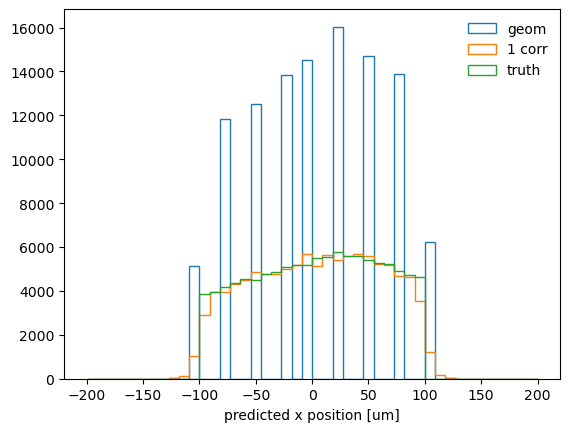

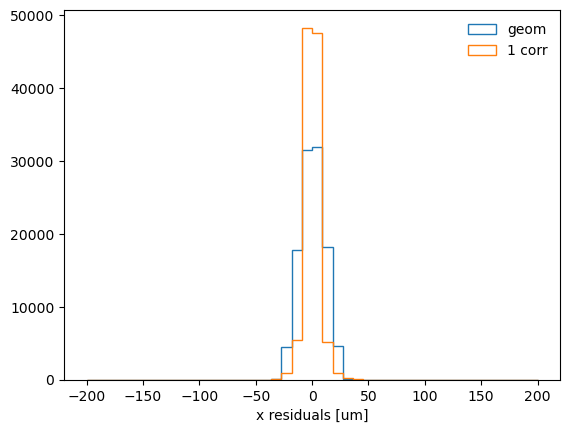

In [20]:
plt.hist(xpred0,bins=xbins,histtype='step',label='geom')
plt.hist(xpred1,bins=xbins,histtype='step',label='1 corr')
#plt.hist(xpred2,bins=bins,histtype='step',label='2 corr')
plt.hist(xtrue,bins=xbins,histtype='step',label='truth')
plt.xlabel("predicted x position [um]")
plt.legend(frameon=False)
plt.show()

plt.hist(xpred0-xtrue,bins=xbins,histtype='step',label='geom')
plt.hist(xpred1-xtrue,bins=xbins,histtype='step',label='1 corr')
plt.xlabel("x residuals [um]")
plt.legend(frameon=False)

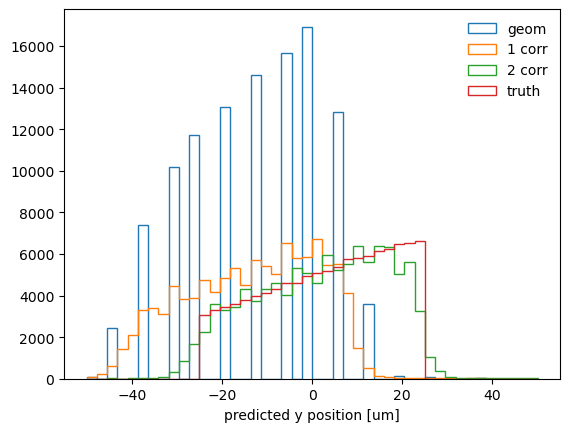

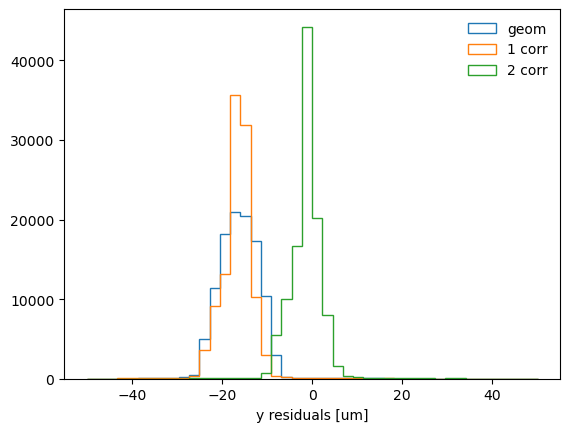

In [21]:
plt.hist(ypred0,bins=ybins,histtype='step',label='geom')
plt.hist(ypred1,bins=ybins,histtype='step',label='1 corr')
plt.hist(ypred2,bins=ybins,histtype='step',label='2 corr')
plt.hist(df['y-midplane'],bins=ybins,histtype='step',label='truth')
plt.xlabel("predicted y position [um]")
plt.legend(frameon=False)
plt.show()

plt.hist(ypred0-df['y-midplane'],bins=ybins,histtype='step',label='geom')
plt.hist(ypred1-df['y-midplane'],bins=ybins,histtype='step',label='1 corr')
plt.hist(ypred2-df['y-midplane'],bins=ybins,histtype='step',label='2 corr')
plt.xlabel("y residuals [um]")
plt.legend(frameon=False)
plt.show()

In [22]:
xresiduals = xpred2 - df['x-midplane']
yresiduals = ypred2 - df['y-midplane']

mean_x = np.mean(xresiduals)
mean_y = np.mean(yresiduals)

interval68 = shortest_interval_68(xresiduals, center_type='mean')
up68_x = interval68['error_high']
down68_x = interval68['error_low']

interval68 = shortest_interval_68(yresiduals, center_type='mean')
up68_y = interval68['error_high']
down68_y = interval68['error_low']


In [23]:
print(mean_x,up68_x,down68_x)

-0.02964286951883637 4.712738318072921 4.384828255893909


In [24]:
print(mean_y,up68_y,down68_y)

-1.3300463382878323 3.0986569596411773 2.408445954889398


Text(0.5, 0, 'y residuals [um]')

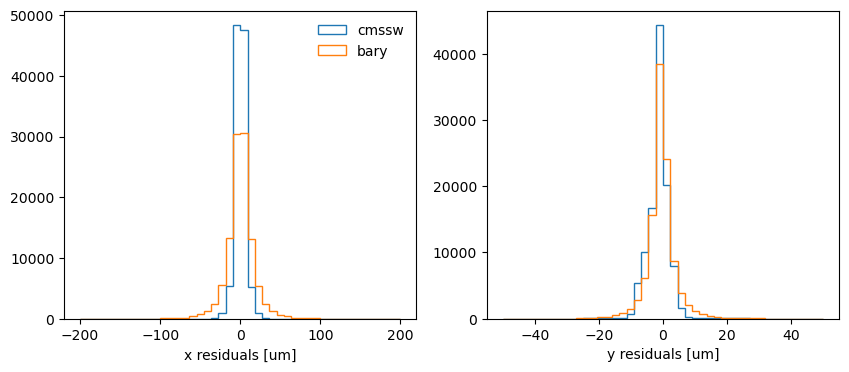

In [25]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(xpred2 - xtrue,bins=xbins,histtype='step',label='cmssw')
ax[0].hist(xbarycenter - xtrue,bins=xbins,histtype='step',label='bary')
ax[0].set_xlabel("x residuals [um]")
ax[0].legend(frameon=False)

ax[1].hist(ypred2 - ytrue,bins=ybins,histtype='step',label='cmssw')
ax[1].hist(ybarycenter - ytrue,bins=ybins,histtype='step',label='bary')
ax[1].set_xlabel("y residuals [um]")